# Refstack Generation

Using `StepByStepRefstackGenerationDeNovo.m`, we generate a reference stack of size $d\times512\times512$ from the glass bead images, with the center at $(x,y) = (259,256)$. As this image is radially symmetric, we can perform a radial average around the center. To achieve this, we use a Gaussian radial basis expansion.

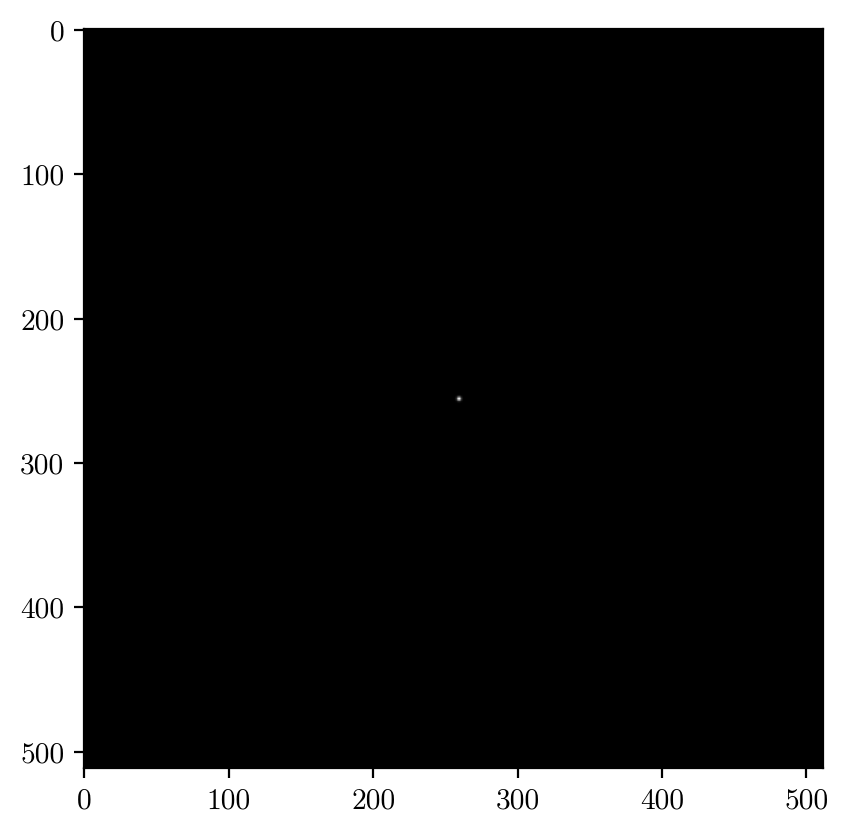

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML,display
from tqdm import tqdm


x0, y0 = 259, 256

def basis_function(grid_size, r):
    y, x = np.meshgrid(np.arange(grid_size[1]), np.arange(grid_size[0]))
    r_sq = (x - x0)**2 + (y - y0)**2
    dist = np.abs(np.sqrt(r_sq) - r)
    return np.exp(-0.5 * dist**2).T

fig = plt.figure();
aximg = plt.imshow(basis_function((512, 512), 1), cmap='gray');

# Create an animation of the basis function
ani = matplotlib.animation.FuncAnimation(fig, lambda i: aximg.set_data(basis_function((512, 512), 2*i)), frames=100,interval=100);
display(HTML(ani.to_jshtml()))

Creating the radial profiles:

In [3]:
import h5py
from tqdm import tqdm # progress bar
from matplotlib.patches import Rectangle

allbeads_refstack = h5py.File("/home/jupyter-till/git/ultralytics/data_gen/FinalRefstack_allbeads_latdrift_corr_min20_temp.mat")
refstack = np.array(allbeads_refstack["Refstack"])

100%|██████████| 1568/1568 [01:22<00:00, 19.07it/s]


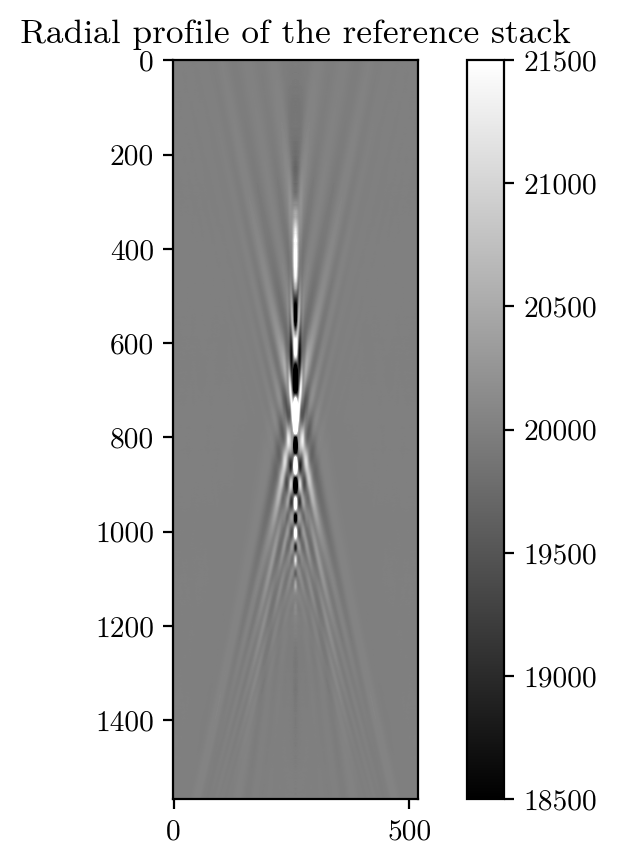

In [ ]:


radial_profile = np.zeros((len(refstack), x0))
masks = np.array([basis_function((512, 512), r) for r in range(x0)])
masks_normalized = (masks.T/masks.sum(axis=(1,2))).T
for i,ripple in (enumerate(tqdm(refstack))):
    for j,mask in enumerate(masks_normalized):
        radial_profile[i,j] = np.sum(ripple*mask)
np.save("radial_profile.npy", radial_profile)

z_mirrored = np.concat([radial_profile[:,::-1],radial_profile],axis=1)
plt.imshow(z_mirrored,vmin=1.85e4,vmax=2.15e4,cmap="grey")
plt.colorbar()
plt.title("Radial profile of the reference stack")
plt.show()

Creating the radially averaged refstack:

In [49]:
radial_profile = np.load("radial_profile.npy")
masks = np.array([basis_function((512, 512), r) for r in range(x0)])
masks_normalized = masks/masks.sum(axis=0)
outside = np.isnan(masks_normalized[0])

def averaged_z_stack(z):
    ripple = np.sum([(masks_normalized[i]*radial_profile[z,i]) for i in range(len(radial_profile[0]))],axis=0)
    ripple[outside] = 2e4
    return ripple

plt.imshow(averaged_z_stack(761), cmap='gray')
plt.colorbar()

from multiprocessing.pool import Pool
radial_averaged_refstack = np.empty((len(radial_profile),512,512))
def make_image(z):
    return z, averaged_z_stack(z)
with Pool() as pool:
    for z, ripple in tqdm(pool.imap(make_image,range(len(radial_profile))),total=len(radial_profile)):
        radial_averaged_refstack[z] = ripple
np.save("radial_averaged_refstack.npy", radial_averaged_refstack)

/tmp/ipykernel_1589809/783093999.py:3: RuntimeWarning: invalid value encountered in divide
  masks_normalized = masks/masks.sum(axis=0)
100%|██████████| 1568/1568 [01:45<00:00, 14.80it/s]


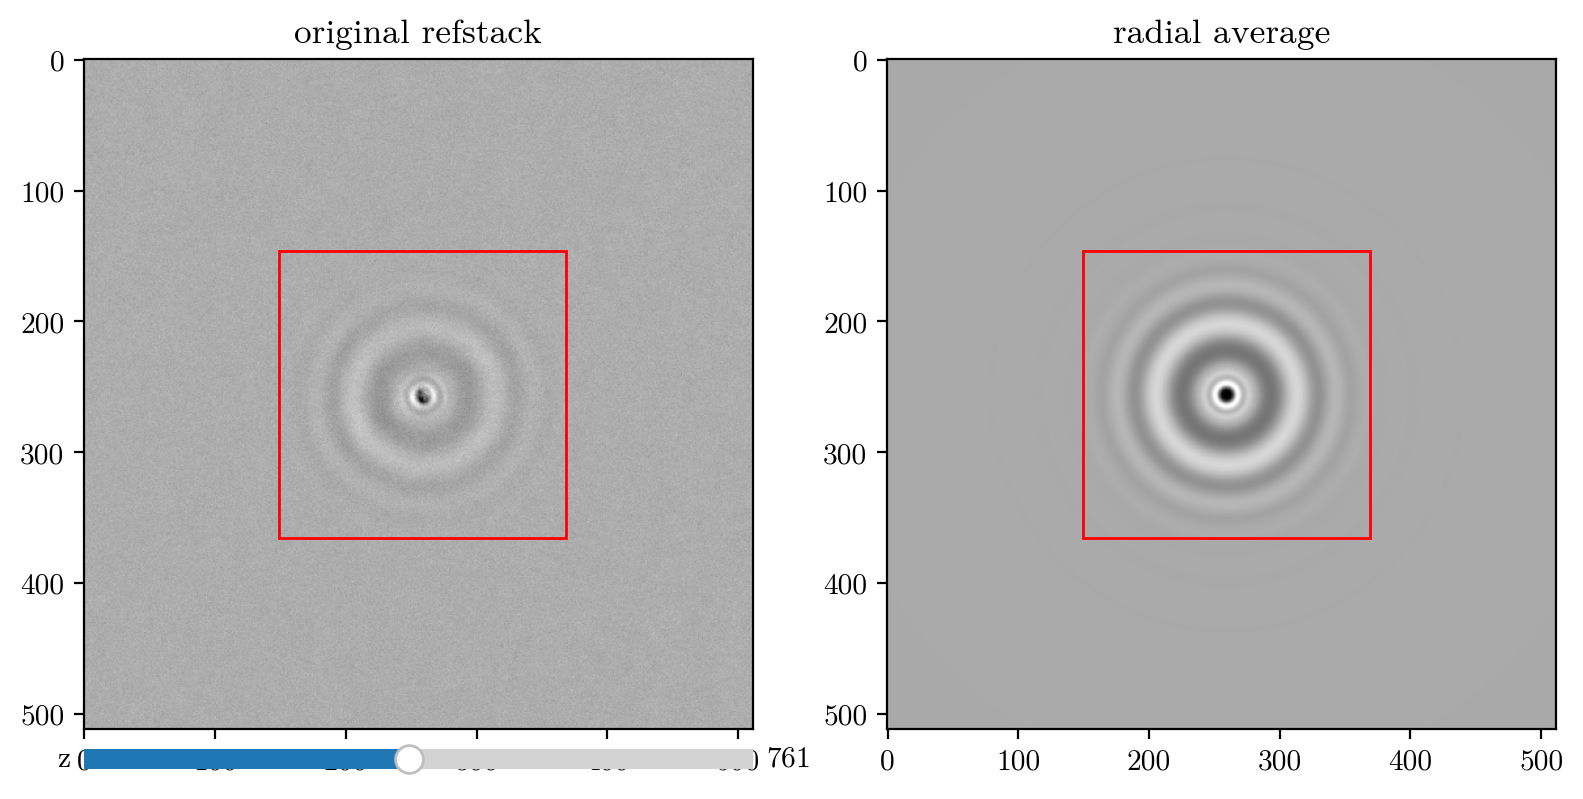

In [4]:
from matplotlib.patches import Rectangle
from matplotlib.widgets import Slider
import h5py
# %matplotlib widget
plt.figure(figsize=(9.5,5))
z=500

radial_averaged_refstack = np.load("radial_averaged_refstack.npy")
bbox_width = np.abs(z-761)*0.21+55


plt.subplot(1,2,1)
plt.title("original refstack")
v = 0.8*np.abs(refstack[z]-2e4).max()

img1 = plt.imshow(refstack[z],cmap="gray")
rectangle1 = Rectangle((x0-bbox_width,y0-bbox_width),bbox_width*2,bbox_width*2,edgecolor="red",facecolor="none")
plt.gca().add_patch(rectangle1)

plt.subplot(1,2,2)
plt.title("radial average")
img2 = plt.imshow(radial_averaged_refstack[z],cmap="gray")
x0,y0 = 259,256
rectangle2 = Rectangle((x0-bbox_width,y0-bbox_width),bbox_width*2,bbox_width*2,edgecolor="red",facecolor="none")
plt.gca().add_patch(rectangle2)

plt.subplot(16,2,31)
slider = Slider(plt.gca(), "z", 0, len(refstack)-1, valinit=761, valstep=1)
slider.on_changed(lambda val: animate(int(val)))
plt.show()
def animate(i):
    z = i
    bbox_width = np.abs(z-761)*0.21+55
    plt.subplot(1,2,1)
    v = 0.8*np.abs(refstack[z]-2e4).max()
    plt.imshow(refstack[z], cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(radial_averaged_refstack[z], cmap="gray")
    rectangle1.set_bounds(x0-bbox_width,y0-bbox_width,bbox_width*2,bbox_width*2)
    rectangle2.set_bounds(x0-bbox_width,y0-bbox_width,bbox_width*2,bbox_width*2)
    print(z , end="\r")
    return img1, img2, rectangle1, rectangle2

# ani = matplotlib.animation.FuncAnimation(fig, animate, frames=1567,interval=1.5);
# display(HTML(ani.to_jshtml()))

Creating downsampled versions of both the original refstack as well as the radially averaged refstack

In [8]:
from cv2 import resize

downsampled_radial_averaged_refstack = np.empty((len(radial_averaged_refstack),128,128))
downsampled_original_refstack = np.empty((len(refstack),128,128))
for i in tqdm(range(len(radial_averaged_refstack))):
    downsampled_radial_averaged_refstack[i] = resize(radial_averaged_refstack[i], (128, 128))
    downsampled_original_refstack[i] = resize(refstack[i], (128, 128))

np.save("downsampled_radial_averaged_refstack.npy", downsampled_radial_averaged_refstack)
np.save("downsampled_original_refstack.npy", downsampled_original_refstack)

100%|██████████| 1568/1568 [00:00<00:00, 6970.65it/s]


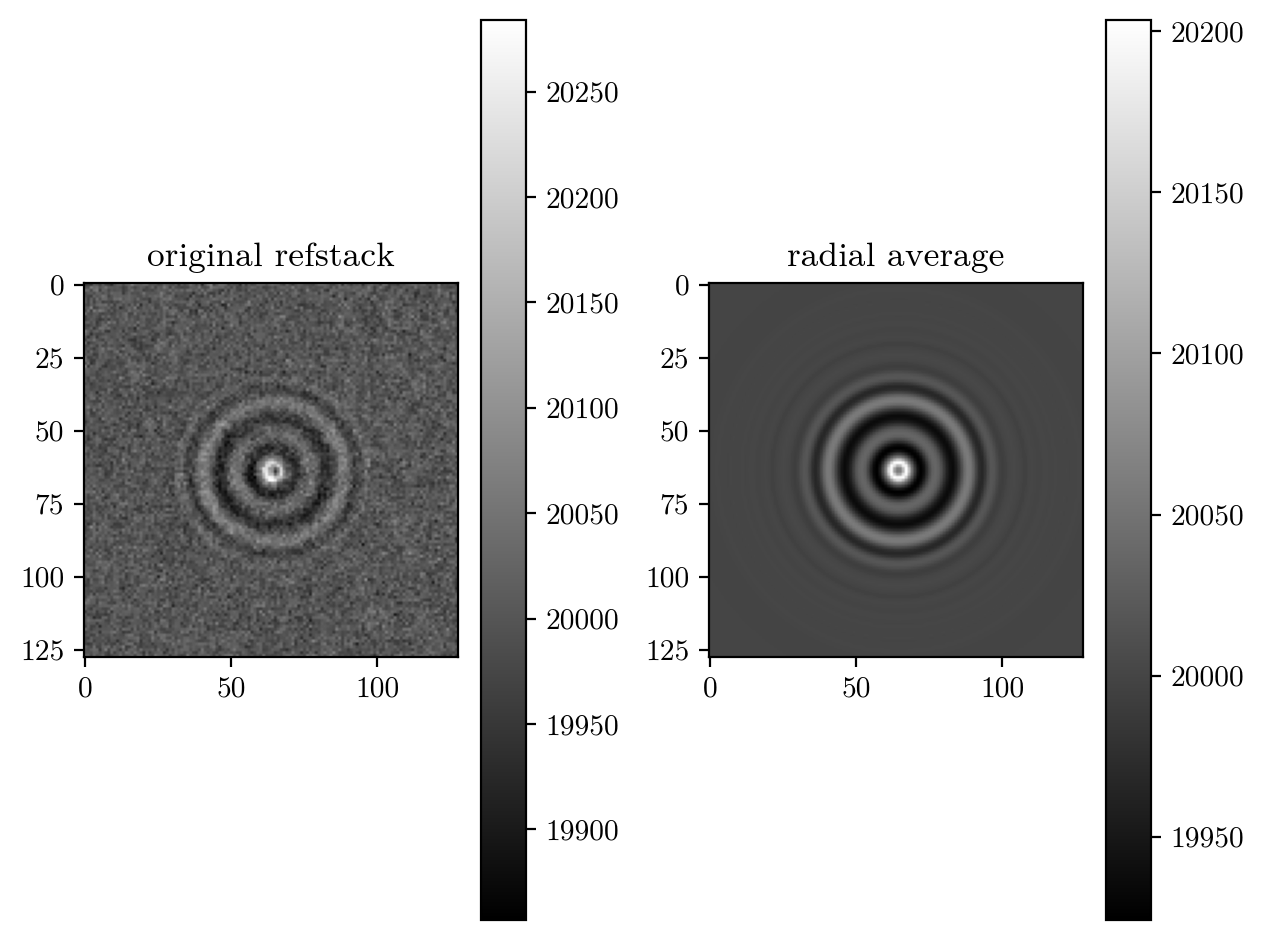

In [6]:
z=300
downsampled_radial_averaged_refstack = np.load("downsampled_radial_averaged_refstack.npy")
downsampled_original_refstack = np.load("downsampled_original_refstack.npy")

plt.subplot(1,2,1)
bbox_width = np.abs(z-761)*0.21+55 / 4
plt.title("original refstack")
plt.imshow(downsampled_original_refstack[z],cmap="gray")
plt.colorbar()
rectangle = Rectangle((x0/4-bbox_width,y0/4-bbox_width),bbox_width*2,bbox_width*2,edgecolor="red",facecolor="none")
plt.gca().add_patch(rectangle)

plt.subplot(1,2,2)
plt.title("radial average")
plt.imshow(downsampled_radial_averaged_refstack[z],cmap="gray")
x0,y0 = 259,256
rectangle = Rectangle((x0/4-bbox_width,y0/4-bbox_width),bbox_width*2,bbox_width*2,edgecolor="red",facecolor="none")
plt.colorbar()
plt.gca().add_patch(rectangle)
plt.tight_layout()
plt.show()
